In [3]:
import numpy as np
import matplotlib.pyplot as plt
import numba
import scipy.integrate as integrate

from numpy import trapz


In [4]:
@numba.njit(fastmath=True, parallel=True, error_model="numpy")
def _integrand_phi(
    k1: float,
    k2: np.ndarray,
    L_2d: float,
    psi: float,
    z_i: float,
    c: float,
    eps: float = 1e-20
) -> tuple[np.ndarray, np.ndarray]:
    """
    Calculates Phi_11(k1, k2) and Phi_22(k1, k2) for a fixed k1 and
    array of k2 values. Accelerated with Numba.

    Parameters
    ----------
        k1: particular k1 value
        k2: range of k2 values to calculate for
        L_2d: Length scale
        psi: anisotropy paramter
        z_i: attenutation length, which we assume = boundary layer height.
        eps: epsilon to avoid divisions by zero with. Default is 1e-20

    Returns
    -------
      tuple[np.ndarray, np.ndarray]: (phi11_values, phi22_values) given params
    """

    phi11 = np.empty_like(k2)
    phi22 = np.empty_like(k2)

    # Precompute some constants
    k1_sq = k1 * k1
    cos_psi = np.cos(psi)
    sin_psi = np.sin(psi)
    L_2d_inv_sq = 1 / (L_2d * L_2d)
    z_i_sq = z_i * z_i
    k1_cos_psi_sq = (k1 * cos_psi) * (k1 * cos_psi)

    for i in range(len(k2)):
        _k2 = k2[i]
        k2_sq = _k2 * _k2

        # Obtain squares of k mag and kappa
        k_mag_sq = k1_sq * k2_sq
        kappa_sq = 2 * (k1_cos_psi_sq + (_k2 * _k2 * sin_psi * sin_psi))

        # Avoid divison by zero
        k_mag_sq = np.max(k_mag_sq, eps)
        kappa_sq = np.max(kappa_sq, eps)
        
        # Obtain "sqrts" of sqs
        kappa = np.sqrt(kappa_sq)

        # E(kappa) calculation
        k_mag = np.sqrt(k_mag_sq)
        denom_factor_1 = (L_2d_inv_sq + k_mag_sq)**(7.0 / 3.0)
        denom_factor_2 = 1 + (kappa_sq * z_i_sq)
        # - Avoid div by zero again
        denom_factor_1 = np.max(denom_factor_1, eps)
        denom_factor_2 = np.max(denom_factor_2, eps)
        
        Ekappa = c * (kappa**3) / (denom_factor_1 * denom_factor_2)
        common_factor = Ekappa / (np.pi * k_mag)

        # Assemble
        phi11[i] = common_factor * (1 - (k2_sq / k_mag_sq))
        phi22[i] = common_factor * (1 - (k1_sq / k_mag_sq))


    return phi11, phi22

@numba.njit(parallel=True, fastmath=True, error_model="numpy")

SyntaxError: unexpected EOF while parsing (2551167270.py, line 73)

In [15]:
class analytical_Fij:

    def __init__(self, config: dict):

        self.L_2d = config["L_2d"]
        self.psi = config["psi"]
        self.sigma2 = config["sigma2"]
        self.z_i = config["z_i"]

        self.c = (8 * self.sigma2) / (9 * (self.L_2d**(2/3)))
        print("c: ", self.c)

    def _phi_leading(self, k1: float, k2: float) -> float:
        """
        Common leading factor E(kappa) / pi * k
        """

        kappa = np.sqrt(
            2 * ((k1 * np.cos(self.psi))**2 + (k2 * np.sin(self.psi))**2)
        )
        k_mag = np.sqrt(k1**2 + k2**2)

        Ekappa = self.c * (kappa**3) / (
            (self.L_2d**-2 + k_mag**2)**(7/3) *\
            (1 + (kappa * self.z_i)**2)
        )

        return Ekappa / (np.pi * k_mag)

    def phi11(self, k1: float, k2: float) -> float:
        """
        Returns F11 for at k1, k2
        """
        _common = self._phi_leading(k1, k2)
        
        k_mag_sq = k1**2 + k2**2
        _P_11 = 1 - (k1**2 / k_mag_sq)

        return _common * _P_11
    
    def phi22(self, k1: float, k2: float) -> float:
        """
        Returns F22 for at k1, k2
        """
        _common = self._phi_leading(k1, k2)

        k_mag_sq = k1**2 + k2**2
        _P_22 = 1 - (k2**2 / k_mag_sq)

        return _common * _P_22


    def generate(self, k1_arr):
        """
        Generate F11 over given k1_arr
        """

        F11_res_arr = np.zeros_like(k1_arr)
        F11_err_arr = np.zeros_like(k1_arr)

        F22_res_arr = np.zeros_like(k1_arr)
        F22_err_arr = np.zeros_like(k1_arr)

        for i, k1 in enumerate(k1_arr):
            F11_res_arr[i], F11_err_arr[i] = integrate.quad(
                lambda _k2: self.phi11(
                    k1, _k2
                ),
                -np.inf, np.inf
            )

            F22_res_arr[i], F22_err_arr[i] = integrate.quad(
                lambda _k2: self.phi22(
                    k1, _k2
                ),
                -np.inf, np.inf
            )

        return F11_res_arr, F11_err_arr, F22_res_arr, F22_err_arr


In [35]:
# Figure 2a (top row)

# NOTE: peak should sit between 0.30 and 0.35, *just* to the right of k1 = 1 / L_2d
phys_config = {
    "L_2d": 100_000.0, # [m]
    "psi": np.deg2rad(45.0),
    "sigma2": 2.0,
    "z_i": 500.0, # [m]
}

k1_values = np.logspace(-1, 3, 500) / phys_config["L_2d"]

analytical_gen = analytical_Fij(phys_config)


c:  0.0008251713481978278


In [36]:
k1_arr_a = np.logspace(-1, 3, 200) / phys_config["L_2d"]
k1_arr_b = np.logspace(0.5, 4.5, 200) / phys_config["L_2d"]

F11_a, F11_err_a, F22_a, F22_err_a = analytical_gen.generate(k1_arr_a)
F11_b, F11_err_b, F22_b, F22_err_b = analytical_gen.generate(k1_arr_b)

print("max k1 F11: ", np.max(k1_arr_a * F11_a))

/var/folders/xr/kfzp127x60q_6gm1sqwbzts40000gn/T/ipykernel_59807/1016551334.py:72: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  F22_res_arr[i], F22_err_arr[i] = integrate.quad(


max k1 F11:  0.2708568232367358


Text(0, 0.5, '$k_1 F_{11}(k_1)$')

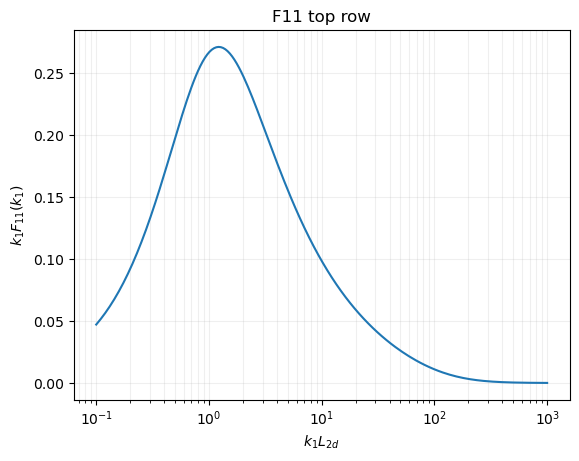

In [37]:
plt.semilogx(k1_arr_a * phys_config["L_2d"], k1_arr_a * F11_a)
plt.grid(which="both", alpha=0.2)
plt.title("F11 top row")
plt.xlabel(r"$k_1 L_{2d}$")
plt.ylabel(r"$k_1 F_{11}(k_1)$")